In [2]:
! pip install requests

  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl (166 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl (128 kB)


You should consider upgrading via the 'F:\GitHub\HSE\dev_ops\hw1\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


6. **Разработка микросервиса предобработки данных**
   - Спроектируйте микросервис для предобработки данных, необходимых для работы вашей модели.
   - Реализуйте сервис с использованием **Flask**, **FastAPI** или другого подходящего фреймворка.
   - Оформите микросервис в виде **Docker-контейнера**.

In [26]:
import requests

url = "http://localhost:8500/preprocess"
files = {"file": open("test_data/8.png", "rb")}

response = requests.post(url, files=files)
response.json()

{'processed_image': [[[[0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    [0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.2823529541492462,
     0.8745098114013672,
     1.0,
     0.8745098114013672,
     0.3764705955982208,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    [0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.2823529541492462,
     0.8745098114013672,
     1.0,
     1.0,
     1.0,
     1.0,
     1.0,
     1.0,
     0.8745098114013672,
     0.3764705955982208,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    [0.0,
     0.0

In [28]:
import requests

url_preprocess = "http://localhost:8500/preprocess"
files = {"file": open("test_data/2.png", "rb")}

try: 
    response = requests.post(url_preprocess, files=files)
    processed_data = response.json()["processed_image"]

    url_triton = "http://localhost:8000/v2/models/pytorch_model/infer"

    payload = {
        "inputs": [{"name": "input", "shape": [1, 1, 28, 28], "datatype": "FP32", "data": processed_data}]
    }

    response = requests.post(url_triton, json=payload)
    print("Предсказание модели:", response.json())
except requests.exceptions.RequestException as e:
    print(f"Ошибка: {e}")

Предсказание модели: {'model_name': 'pytorch_model', 'model_version': '1', 'outputs': [{'name': 'output', 'datatype': 'FP32', 'shape': [1, 10], 'data': [-0.4514937698841095, -2.389416456222534, 2.7427754402160645, -0.5728253722190857, -1.9728140830993652, -4.17232084274292, -1.4651753902435303, -6.641538143157959, -3.000552177429199, -4.277719497680664]}]}


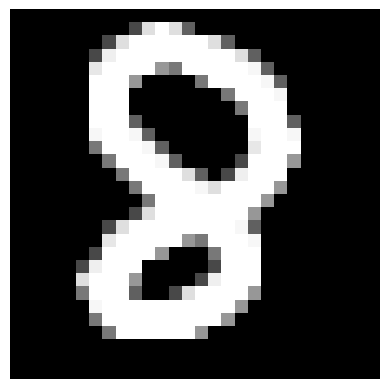

In [24]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Загружаем и показываем исходное изображение
img_path = "test_data/8.png"
image = Image.open(img_path).convert("L")  # ч/б
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()


In [16]:
import requests
import numpy as np

url_preprocess = "http://localhost:8500/preprocess"
files = {"file": open("test_data/8.png", "rb")}

try: 
    # Отправляем изображение в микросервис предобработки
    response = requests.post(url_preprocess, files=files)
    processed_data = response.json()["processed_image"]

    # Отправляем инференс в Triton
    url_triton = "http://localhost:8000/v2/models/pytorch_model/infer"
    payload = {
        "inputs": [{
            "name": "input",
            "shape": [1, 1, 28, 28],
            "datatype": "FP32",
            "data": processed_data
        }]
    }

    response = requests.post(url_triton, json=payload)
    result = response.json()

    # Извлекаем выходные данные
    output_data = result["outputs"][0]["data"]

    # Преобразуем в numpy и выводим индекс максимума
    prediction = int(np.argmax(output_data))
    print("prediction:", prediction)

except requests.exceptions.RequestException as e:
    print(f"Ошибка: {e}")


prediction: 8
